# **Кейс №4. Золотая жила - 2. Алексеев Виталий**
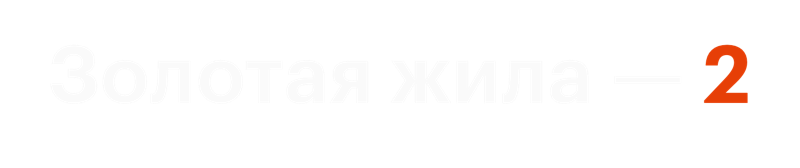
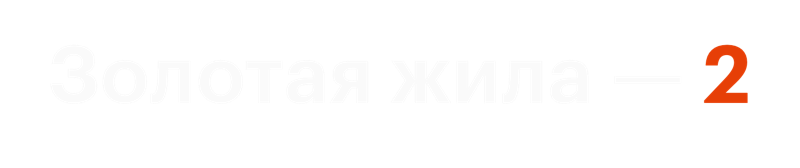

## **0 Импорт библиотек**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns

plt.style.use("ggplot")

## **1 Загрузка данных. Первичная обработка**

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/zalig/cu-datasets/main/golden_mine.csv"
)
df["Gender"] = pd.Categorical(values=df["Gender"].map(
    lambda s: s.lower()), categories=["male", "female"]
)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Payments  8715 non-null   int64   
 1   Costs     8715 non-null   int64   
 2   Profit    8715 non-null   int64   
 3   Age       8715 non-null   int64   
 4   Gender    8715 non-null   category
 5   AgeGroup  8715 non-null   object  
dtypes: category(1), int64(4), object(1)
memory usage: 349.2+ KB


,Payments,Costs,Profit,Age,Gender,AgeGroup
0,9400,8100,1300,19,male,18-24
1,26600,13900,12700,29,male,25-39
2,9750,6750,3000,20,male,18-24
3,29700,11200,18500,18,female,18-24
4,49700,10450,39250,21,female,18-24
5,14300,7500,6800,18,male,18-24
6,30300,11400,18900,18,female,18-24
7,53100,17800,35300,21,female,18-24
8,10300,7700,2600,18,male,18-24
9,111400,35650,75750,21,male,18-24


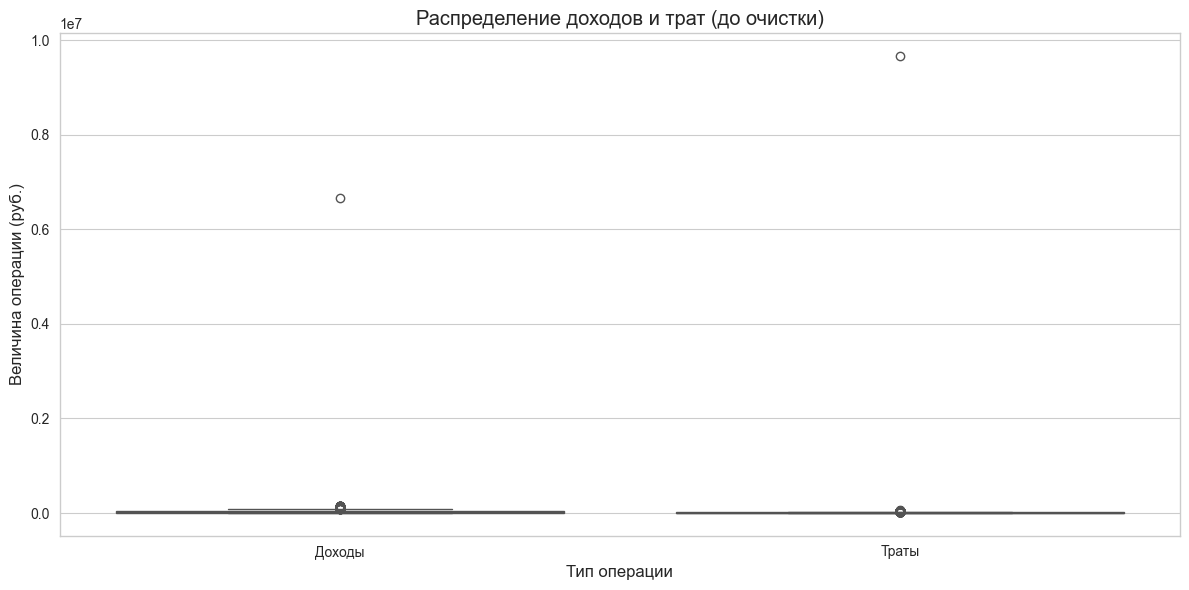

In [3]:
df_long = pd.melt(df, value_vars=['Payments', 'Costs'],
                  var_name='Type', value_name='Amount')
df_long['Type_ru'] = df_long['Type'].replace({'Payments': 'Доходы', 'Costs': 'Траты'})

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=df_long, y='Amount', x='Type_ru', ax=ax)
plt.title("Распределение доходов и трат (до очистки)")
plt.ylabel("Величина операции (руб.)")
plt.xlabel("Тип операции")
plt.tight_layout()
plt.show()

In [4]:
df.drop(index=df["Payments"].idxmax(), axis=0, inplace=True)
df.drop(index=df["Costs"].idxmax(), axis=0, inplace=True)

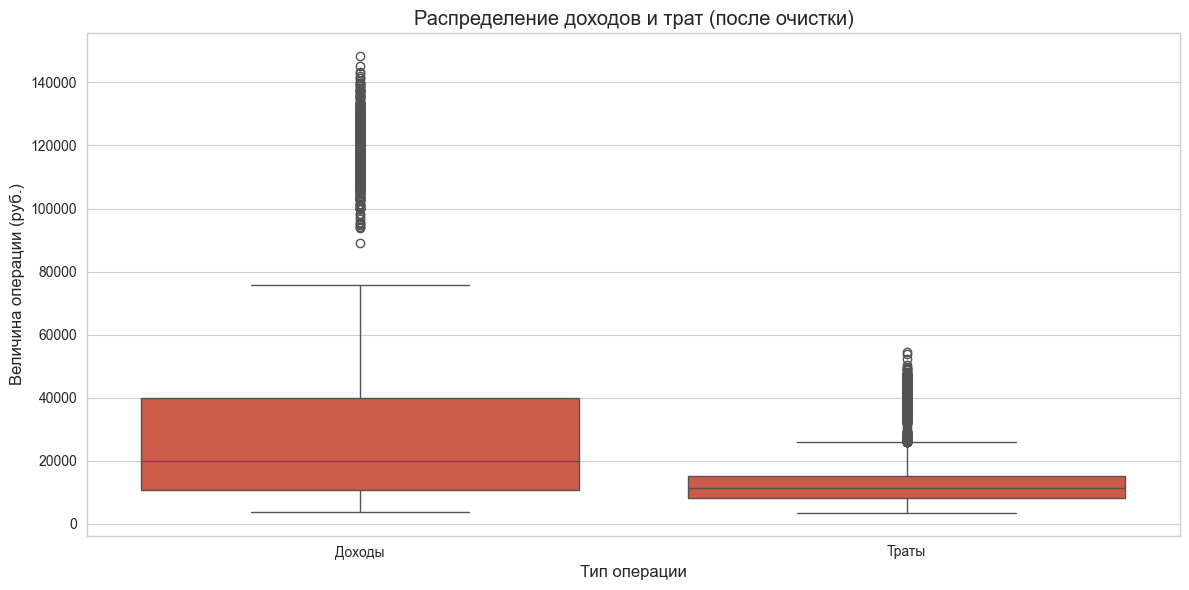

In [5]:
df_long = pd.melt(df, value_vars=['Payments', 'Costs'],
                  var_name='Type', value_name='Amount')
df_long['Type_ru'] = df_long['Type'].replace({'Payments': 'Доходы', 'Costs': 'Траты'})

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=df_long, y='Amount', x='Type_ru', ax=ax)
plt.title("Распределение доходов и трат (после очистки)")
plt.ylabel("Величина операции (руб.)")
plt.xlabel("Тип операции")
plt.tight_layout()
plt.show()

In [6]:
print(f"Средняя прибыль с одного клиента: {df["Profit"].mean()} ₽")

Средняя прибыль с одного клиента: 15755.095833811545 ₽


## **2 Оценка статистической значимости прибыльности привлечения клиентов без таргетирования**

Проведем следующий тест, который поможет выяснить: прибыльно ли вообще привлекать новых клиентов. Тогда имеем:
$$H_0:\mu_{profit}=15\;000,\quad H_1:\mu_{profit}>15\;000$$
где $ \mu_{profit}$ - параметр, означающий среднюю прибыль с одного клиента после привлечения новых клиентов (в случае нулевой гипотезы мы вообще не проводим рекламную компанию, следовательно, не привлекаем новых клиентов, тогда средняя прибыль останется на том же уровне).

Поскольку $n=8715$ - достаточно велико, то можем применить одновыборочный $t$-тест. Тестовая статистика в этом случае:
$$t_{st}=\frac{\overline{X}-15\;000}{s / n}\sim t(1)$$

In [7]:
sps.ttest_1samp(df['Profit'], 15_000, alternative='greater')

TtestResult(statistic=np.float64(3.5021147923588205), pvalue=np.float64(0.0002319469578629102), df=np.int64(8712))

Таким образом (на уровне значимости $\alpha=5\%$):
$$t_{\text{набл}}\approx 3,5,\quad \text{p-value}\approx 0,02\%<5\%=\alpha$$
Таким образом, тест статистически **значим**, значит $H_0$ отклоняется и привлекать клиентов, даже без таргетирования, целесообразно и выгодно.

In [8]:
print(
    f"Ожидаемый экономический эффект с кампании: {(df["Profit"].mean() - 15_000) * 1000} ₽"
)

Ожидаемый экономический эффект с кампании: 755095.8338115452 ₽


## **3 А/Б тесты для разных подвыборок - 1**

### **3.1 Мужчины 18-24 лет & Женщины 18-24 лет**

In [9]:
men_18_24 = df.loc[(df["Gender"] == "male") & (df["AgeGroup"] == "18-24"), 'Profit']
women_18_24 = df.loc[(df["Gender"] == "female") & (df["AgeGroup"] == "18-24"), 'Profit']

sps.ttest_ind(
    men_18_24,
    women_18_24,
    equal_var=False,
    alternative='two-sided'
)

TtestResult(statistic=np.float64(-27.09280730417151), pvalue=np.float64(3.121342839161316e-150), df=np.float64(4654.958106413043))

Как можно заметить, значение p-value катастрофически мало, порядка $10^{-150}$, интересный факт: размер электрона составляет $10^{-15}$ м, что на $135$ порядков выше найденной величины - настолько она мала.

Возвращаясь к результату теста, он статистически **значим**, поскольку p-value $<\alpha=5\%$. Таким образом, между привлечением мужчин и женщин категории 18-24 лет есть статистическая, и следовательно, экономическая разница.

In [10]:
print(
    f"Ожидаемый экономическая разница с кампании: {abs(men_18_24.mean() - women_18_24.mean()) * 1000} ₽"
)

Ожидаемый экономическая разница с кампании: 13122611.458360896 ₽


### **3.2 Мужчины 18-24 лет**

In [11]:
sps.ttest_1samp(men_18_24, 15_000, alternative='greater')

TtestResult(statistic=np.float64(-4.065077065970155), pvalue=np.float64(0.9999754895084132), df=np.int64(3678))

Результаты:
$$\text{p-value}\approx 99,998\% > \alpha=5\%$$
Тест статистически **не значим**. Значит, привлечение данной категории нецелесообразно.

### **3.3 Женщины 18-24 лет**

In [12]:
sps.ttest_1samp(women_18_24, 15_000, alternative='greater')

TtestResult(statistic=np.float64(66.48342590449388), pvalue=np.float64(0.0), df=np.int64(2711))

Результаты:
$$\text{p-value}\approx 0\% < \alpha=5\%$$
Тест статистически **значим**. Значит, привлечение данной категории целесообразно и выгодно.

In [13]:
print(
    f"Ожидаемый экономический эффект с кампании: {(women_18_24.mean() - 15_000) * 1000} ₽"
)

Ожидаемый экономический эффект с кампании: 11278373.89380531 ₽


## **4 А/Б тесты для разных подвыборок - 2**

### **4.1 Женщины 18-21 и 22-24 лет**

In [14]:
df["AgeGroup"].unique()

array(['18-24', '25-39', '40+'], dtype=object)

In [15]:
women_18_21 = df.loc[(df["Gender"] == "female") & (df["Age"].between(18, 21)), 'Profit']
women_22_24 = df.loc[(df["Gender"] == "female") & (df["Age"].between(22, 24)), 'Profit']
sps.ttest_ind(
    women_18_21,
    women_22_24,
    equal_var=False,
    alternative='two-sided'
)

TtestResult(statistic=np.float64(-8.481210212854762), pvalue=np.float64(2.734757386345865e-16), df=np.float64(483.095693750638))

Аналогично п. 3.1, тест показал сильную статистическую значимость, значит от выбора категории сильно зависит итоговый экономический эффект кампании.

### **4.2 Женщины 18-21 лет**

In [16]:
sps.ttest_1samp(women_18_21, 15_000, alternative='greater')

TtestResult(statistic=np.float64(59.57084569971796), pvalue=np.float64(0.0), df=np.int64(2346))

In [17]:
n = len(women_18_21)
std_profit = women_18_21.std(ddof=1)
CAC = 15_000

alpha = 0.05
power = 0.80
beta = 1 - power

t_alpha = sps.t.ppf(1 - alpha, df=n-1)
t_beta = sps.t.ppf(1 - beta, df=n-1)

MDE_absolute = (t_alpha + t_beta) * (std_profit / np.sqrt(n))
print(f"MDE = {MDE_absolute} ₽")

MDE = 447.44940295614236 ₽


_Прим._ CAC (Customer Acquisition Cost) - это метрика стоимости привлечения клиента, показывающая, сколько денег компания тратит на маркетинг и продажи, чтобы получить одного нового покупателя.

### **4.3 Женщины 22-24 лет**

In [18]:
sps.ttest_1samp(women_22_24, 15_000, alternative='greater')

TtestResult(statistic=np.float64(32.50075312037019), pvalue=np.float64(5.90586930392315e-110), df=np.int64(364))

In [19]:
n = len(women_22_24)
std_profit = women_22_24.std(ddof=1)
CAC = 15_000

alpha = 0.05
power = 0.80
beta = 1 - power

t_alpha = sps.t.ppf(1 - alpha, df=n-1)
t_beta = sps.t.ppf(1 - beta, df=n-1)

MDE_absolute = (t_alpha + t_beta) * (std_profit / np.sqrt(n))
print(f"MDE = {MDE_absolute} ₽")

MDE = 1141.6318465002694 ₽


Для обоих тестов получили p-value крайне малым (почти нулевое), поэтому обе гипотезы, с точки зрения статистического значения, являются целесообразными, т.е. покрывают расходы на привлечение. Кроме того, вне зависимости от уровня мощности, даже если принять его $1\%$ или $0,1\%$, тест все равно будет статистически значимым.

Однако MDE при этом выше у второй категории, поэтому с точки зрения эконической значимсоти, целесообразнее выбрать именно ее.

### **4.4 Женщины 18, 19, 20, ... 24 лет**

In [21]:
alpha = 0.05 / 21

for first_age in range(18, 25):
    for second_age in range(first_age + 1, 25):
        first = df.loc[(df["Gender"] == "female") & (df["Age"] == first_age), 'Profit']
        second = df.loc[(df["Gender"] == "female") & (df["Age"] == second_age), 'Profit']
        stat, p_value = sps.ttest_ind(
            women_18_21,
            women_22_24,
            equal_var=False,
            alternative='two-sided'
        )
        if p_value <= alpha:
            print(f"{first_age} & {second_age} - {True}")

18 & 19 - True
18 & 20 - True
18 & 21 - True
18 & 22 - True
18 & 23 - True
18 & 24 - True
19 & 20 - True
19 & 21 - True
19 & 22 - True
19 & 23 - True
19 & 24 - True
20 & 21 - True
20 & 22 - True
20 & 23 - True
20 & 24 - True
21 & 22 - True
21 & 23 - True
21 & 24 - True
22 & 23 - True
22 & 24 - True
23 & 24 - True


Таким образом, попарное тестирование значимости прибыли от двух категорий показало, что между всеми ними **присутствует** статистическая разница.

## **5 Золотая жила**

### **5.1 Золотая жила на графике**

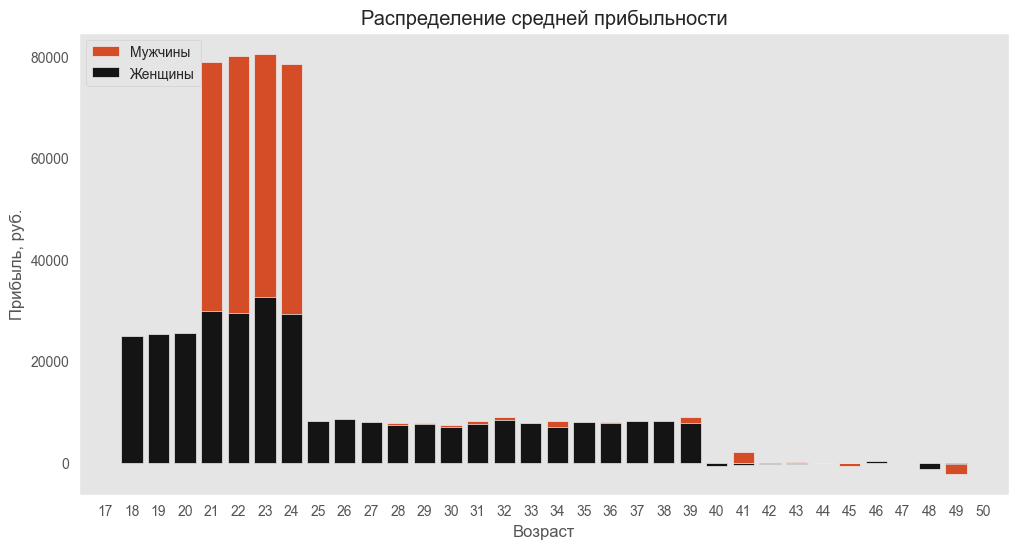

In [43]:
df_mean = df.pivot_table("Profit", index="Age", columns="Gender", aggfunc="mean", observed=True)

plt.figure(figsize=(12, 6))
plt.title("Распределение средней прибыльности")
plt.xlabel("Возраст")
plt.xticks(np.arange(0, 60))
plt.ylabel("Прибыль, руб.")
plt.bar(df_mean.index, df_mean["male"], label="Мужчины", color="#D44D26")
plt.bar(df_mean.index, df_mean["female"], label="Женщины", color="#141414")
plt.grid(False)
plt.legend()
plt.show()

### **5.2 А/Б тест разницы с категорией женщины 18-24 лет**

In [44]:
men_21_24 = df.loc[(df["Gender"] == "male") & (df["Age"].between(21, 24)), 'Profit']
sps.ttest_ind(
    men_21_24,
    women_18_24,
    equal_var=False,
    alternative='two-sided'
)

TtestResult(statistic=np.float64(104.86410083908082), pvalue=np.float64(0.0), df=np.float64(668.1432153213934))

Тест показал p-value $\approx 0%$, что явно говорит о сильной статистической **значимости** данной разницы.

## **6 А/Б тесты для категорий мужчины 18 ... 24 лет**

### **6.1 MDE для категории мужчины 18 лет**

In [46]:
men_18 = df.loc[(df["Gender"] == "male") & (df["Age"] == 18), 'Profit']
n = len(men_18)
std_profit = men_18.std(ddof=1)
CAC = 15_000

alpha = 0.05
power = 0.80
beta = 1 - power

t_alpha = sps.t.ppf(1 - alpha, df=n-1)
t_beta = sps.t.ppf(1 - beta, df=n-1)

MDE_absolute = (t_alpha + t_beta) * (std_profit / np.sqrt(n))
print(f"MDE = {MDE_absolute} ₽")

MDE = 144.98182781988723 ₽


Таким обрзом для всей рекламной кампании эффект составит $\approx 145\;000$ рублей.

### **6.2 MDE для серии тестов в категориях мужчины 18 ... 24 лет**

Для начала разберемся с математической моделью. Будем перебирать возможные значения MDE (поэтому итоговый ответ, очевидно, будет не абсолютно точным, а с выбранной нами точностью, учитывая порядок результата из предыдущего пункта, логично выбрать точность $10^{-1}$), для каждого из них будем считать мощность серии, как для независимых событий, т.е. итоговая мощность есть произведение мощностей всех тестов в серии:
$$power_{total}=\prod_{i=1}^npower_i$$
Требуем:
$$power_{total}\ge 80\%$$
Учитывая поправку Бонферрони, уровень значимости каждого из тестов составит:
$$\alpha_i=\frac{\alpha}{n}=\frac{5\%}{7}\approx 0,71\%$$

In [48]:
ages = np.arange(18, 25)
n_values = [len(df.loc[(df["Gender"] == "male") & (df["Age"] == age)]) for age in ages]
s_values = [np.std(df.loc[(df["Gender"] == "male") & (df["Age"] == age), "Profit"], ddof=1) for age in ages]

total_alpha = 0.05
alpha_ind = total_alpha / len(ages)
target_power = 0.80
CAC = 15_000

def series_power(MDE):
    beta_product = 1.0

    for i in range(len(ages)):
        n = n_values[i]
        df = n - 1
        beta_product *= sps.t.cdf(sps.t.ppf(1 - alpha_ind, df) - MDE / (s_values[i] / np.sqrt(n)), df)

    return 1 - beta_product

low, high = 0, 500
step = 0.1

while high - low > step:
    mid = (low + high) / 2
    power_mid = series_power(mid)

    if power_mid >= target_power:
        high = mid
    else:
        low = mid

MDE_final = (low + high) / 2
print(f"MDE = {MDE_final}₽")

MDE = 151.519775390625₽


Значит, искомый MDE для всей кампании составит $\approx 151\;500$ ₽.